# Analyze of a trapped particle

## Still to do
- Reduce the size of the ACF, PSD and MSD plot
- determination of the spatial resolution by the PSD
- PSD hydrodynamic fit should work
- MSD hydrodynamic fit
- binning for MSD and VACF
- VACF
- VACF fit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math
pi = np.pi
from numpy.random import *
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'
from scipy.optimize import curve_fit
plt.rcParams.update({'font.size': 16})

def autocorrFFT(x):
    N=len(x)
    F = np.fft.fft(x, n=2*N)  #2*N because of zero-padding
    PSD = F * F.conjugate()
    res = np.fft.ifft(PSD)
    res= (res[:N]).real   #now we have the autocorrelation in convention B
    n=N*np.ones(N)-np.arange(0,N) #divide res(m) by (N-m)
    return res/n #this is the autocorrelation in convention A

def msd_fft(r):
    N=len(r)
    D=np.square(r).sum(axis=1) 
    D=np.append(D,0) 
    S2=sum([autocorrFFT(r[:, i]) for i in range(r.shape[1])])
    Q=2*D.sum()
    S1=np.zeros(N)
    for m in range(N):
        Q=Q-D[m-1]-D[N-m]
        S1[m]=Q/(N-m)
    return S1-2*S2

def fitACF(x,tau):
    return ACFmean[0]*np.exp(-x/tau)

def fitPSD(x,fk,A):
    return A*kB*T/(2*pow(np.pi,2)*drag*(pow(fk,2)+pow(x,2)))

def fitPSDhydro(f,f_f):
    prefactor = Diff_const/(2*np.pi**2*f**2)
    numerator = 1+np.sqrt(f/(2*f_f))
    divider = (f_k/f-np.sqrt(f/(2*f_f))-f/f_p-f/(9*f_f))**2+(1+np.sqrt(f/(2*f_f)))**2
    return A*prefactor*numerator/divider

def fitMSD(x,tau):
    return 2*kB*T*tau/drag*(1-np.exp(-x/tau))

def chi2(ydata,Nparams,f, *params):
    res = ydata - f(*params)
    redchi2 = sum(res**2)/(len(ydata)-Nparams)
    return res, redchi2

def chi2abs(ydata,yErr,Nparams,f,*params):
    res = ydata - f(*params)
    redchi2 = sum((res/yErr)**2)/(len(ydata)-Nparams)
    return res, redchi2

In [2]:
dt = 100e-9       #frame rate 0.1 µs
datasets = 1      #how many datasets

Diameter = 2.19e-6     #parameters for analysis
R = Diameter/2
T = 273.15+20.9
kB = 1.38064852e-23
eta = 2.414e-5*10**(247.8/(T-140))
drag = 6*np.pi*eta*R
rho_p = 1040
rho_f = 998
V_p = 4.0/3*np.pi*R**3
M_p = rho_p*V_p
k = 1e-6
tau_p = M_p/(6*np.pi*eta*R)
tau_f = R**2*rho_f/eta
tau_k = 6*np.pi*eta*R/k
Diff_const=kB*T/drag
M_f = rho_f*V_p
M_eff = M_p + M_f/2
f_p=1/(2*np.pi*tau_p)
f_f=1/(2*np.pi*tau_f)
f_k=1/(2*np.pi*tau_k)

## Load the data from txt files

In [3]:
start_time = time.time()      #load datasets from txt-files
for i in range(datasets):
    xload = np.loadtxt('/Users/alex/Documents/HBM/Xiaoya/Data/100ns/'+str(i)+'.txt')
    length = len(xload)
    if i == 0: x = np.zeros((length,datasets))
    x[:,i] = xload   
print("--- %s seconds ---" % round((time.time() - start_time),2)) 
timewave = np.linspace(0,length*dt,length,endpoint=False)

--- 36.6 seconds ---


## Calculate the ACF (and estimate the error range)

In [5]:
start_time = time.time()             #calculate the ACF for every trajectory
ACF = np.zeros((length,datasets))
ACFmean = np.zeros(length)
for i in range(datasets):
    ACFcalc = autocorrFFT(x[:,i])
    ACF[:,i] = ACFcalc
    ACFmean += ACFcalc
ACFmean /= datasets

#ACFerr = np.zeros(length)           #estimate the error of the ACF --- time consuming procedure!!!
#for i in range(length):             #comment out if not needed!
#    ACFerr[i] = np.std(ACF[i,:])/np.sqrt(datasets)
print("--- %s seconds ---" % round((time.time() - start_time),2))  

--- 144.56 seconds ---


## Plot the ACF and fit the expected function

1 V =  0.665  µm
tau_k =  0.864  +-  0.001 ms


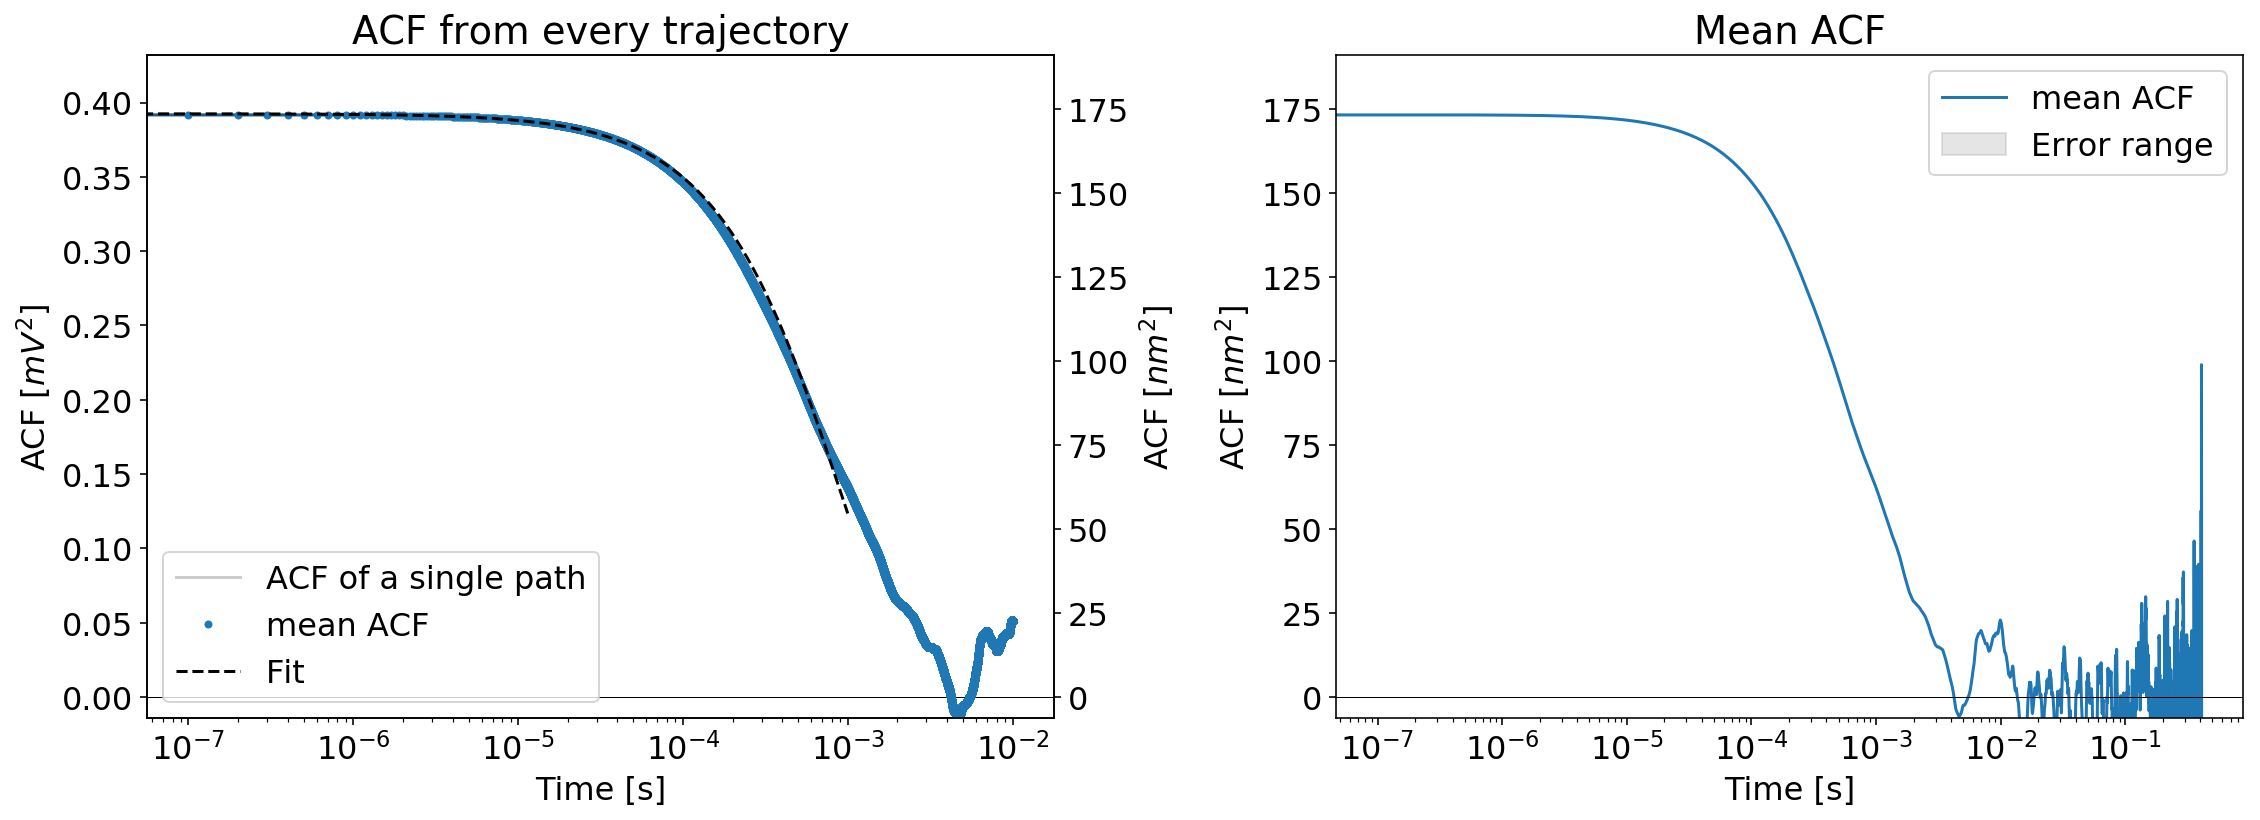

--- 58.93 seconds ---


In [6]:
start_time = time.time()
plottime = 0.01
plotlength = int(plottime/dt)
fittime = 0.001
fitlength = int(fittime/dt)

popt,pcov = curve_fit(fitACF, timewave[:fitlength], ACFmean[:fitlength],p0 = (0.001))
pErr = np.sqrt(np.diag(pcov))
r,redchi2 = chi2(ACFmean,1,fitACF,timewave,*popt)

taukACF = popt[0];taukACFerr = pErr[0]
Atheo = kB*T*taukACF/drag
Vtom = np.sqrt(Atheo/ACFmean[0])
print('1 V = ',round(Vtom*1e6,3),' µm')
print('tau_k = ',round(taukACF*1e3,3),' +- ',round(taukACFerr*1e3,3),'ms')
Conversiontonm = Vtom**2*1e18
ACFinnm = ACFmean*Conversiontonm

ACFmax = 1.1*ACF[:plotlength].max()
ACFmin = 1.1*ACF[:plotlength].min()

fig, ax1 = plt.subplots(figsize=(16,6))
ax = plt.subplot(121)
ax.set_xlabel('Time [s]')
ax.set_ylabel('ACF [$mV^{2}$]')
ax.tick_params(axis='y')
plt.semilogx(timewave[:plotlength],ACFmean[:plotlength]*1e3)
plt.axhline(y=0,linewidth=0.5, color = 'k',linestyle='-')
plt.ylim([ACFmin*1e3,ACFmax*1e3])
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
for i in range(datasets):
    if i == 0:
        plt.semilogx(timewave[:plotlength],ACF[:plotlength,i]*Conversiontonm,c='k',alpha=0.2,label = 'ACF of a single path')
    else:
        plt.semilogx(timewave[:plotlength],ACF[:plotlength,i]*Conversiontonm,c='k',alpha=0.2)
plt.semilogx(timewave[:plotlength],ACFinnm[:plotlength],'.',label='mean ACF')
plt.plot(timewave[:fitlength],fitACF(timewave[:fitlength],*popt)*Conversiontonm,'k--',label='Fit')
plt.ylim([ACFmin*Conversiontonm,ACFmax*Conversiontonm])
ax2.set_ylabel('ACF [$nm^{2}$]')  # we already handled the x-label with ax1
ax2.tick_params(axis='y')
plt.title('ACF from every trajectory')
plt.legend()

plt.subplot(122)
plt.semilogx(timewave, ACFinnm,label = 'mean ACF')
plt.fill_between(timewave, ACFinnm - ACFerr*Conversiontonm, 
                 ACFinnm + ACFerr*Conversiontonm,
                 color='gray', alpha=0.2, label = 'Error range')
plt.axhline(y=0,linewidth=0.5, color = 'k',linestyle='-')
plt.xlabel('Time [s]')
plt.ylabel('ACF [$nm^{2}$]')
plt.ylim([ACFmin*Conversiontonm,ACFmax*Conversiontonm])
plt.title('Mean ACF')
plt.legend()
plt.tight_layout()  
plt.savefig('ACF.pdf', format='pdf')
plt.show()
print("--- %s seconds ---" % round((time.time() - start_time),2))  

In [8]:
start_time = time.time()
PSD = np.zeros((int(length/2),datasets))
PSDmean = np.zeros(int(length/2))
for i in range(datasets):
    F = np.fft.fft(x[:,i], n=length)
    PSDcalc = F * F.conjugate()
    PSDcalc = np.real(PSDcalc)/(length*(2*length+1))
    PSD[:,i] = PSDcalc[:int(length/2)]
    PSDmean += PSDcalc[:int(length/2)]
PSDmean /= datasets
freq = np.fft.fftfreq(timewave.shape[-1],dt*length/timewave.shape[-1])
freq = freq[:int(length/2)]

PSDerr = np.zeros(int(length/2))
for i in range(int(length/2)):
    PSDerr[i] = np.std(PSD[i,:])/np.sqrt(datasets)
print("--- %s seconds ---" % round((time.time() - start_time),2))  

--- 81.05 seconds ---


From the simple fit:
tau_k =  1.417  +-  0.012  ms
 
From the hydrodynamic fit:
tau_f =  1.221  +-  inf  µs - theory:  1.221


/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:40: RuntimeWarning: divide by zero encountered in true_divide
/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in true_divide
/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in true_divide
/Users/alex/anaconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/alex/anaconda/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


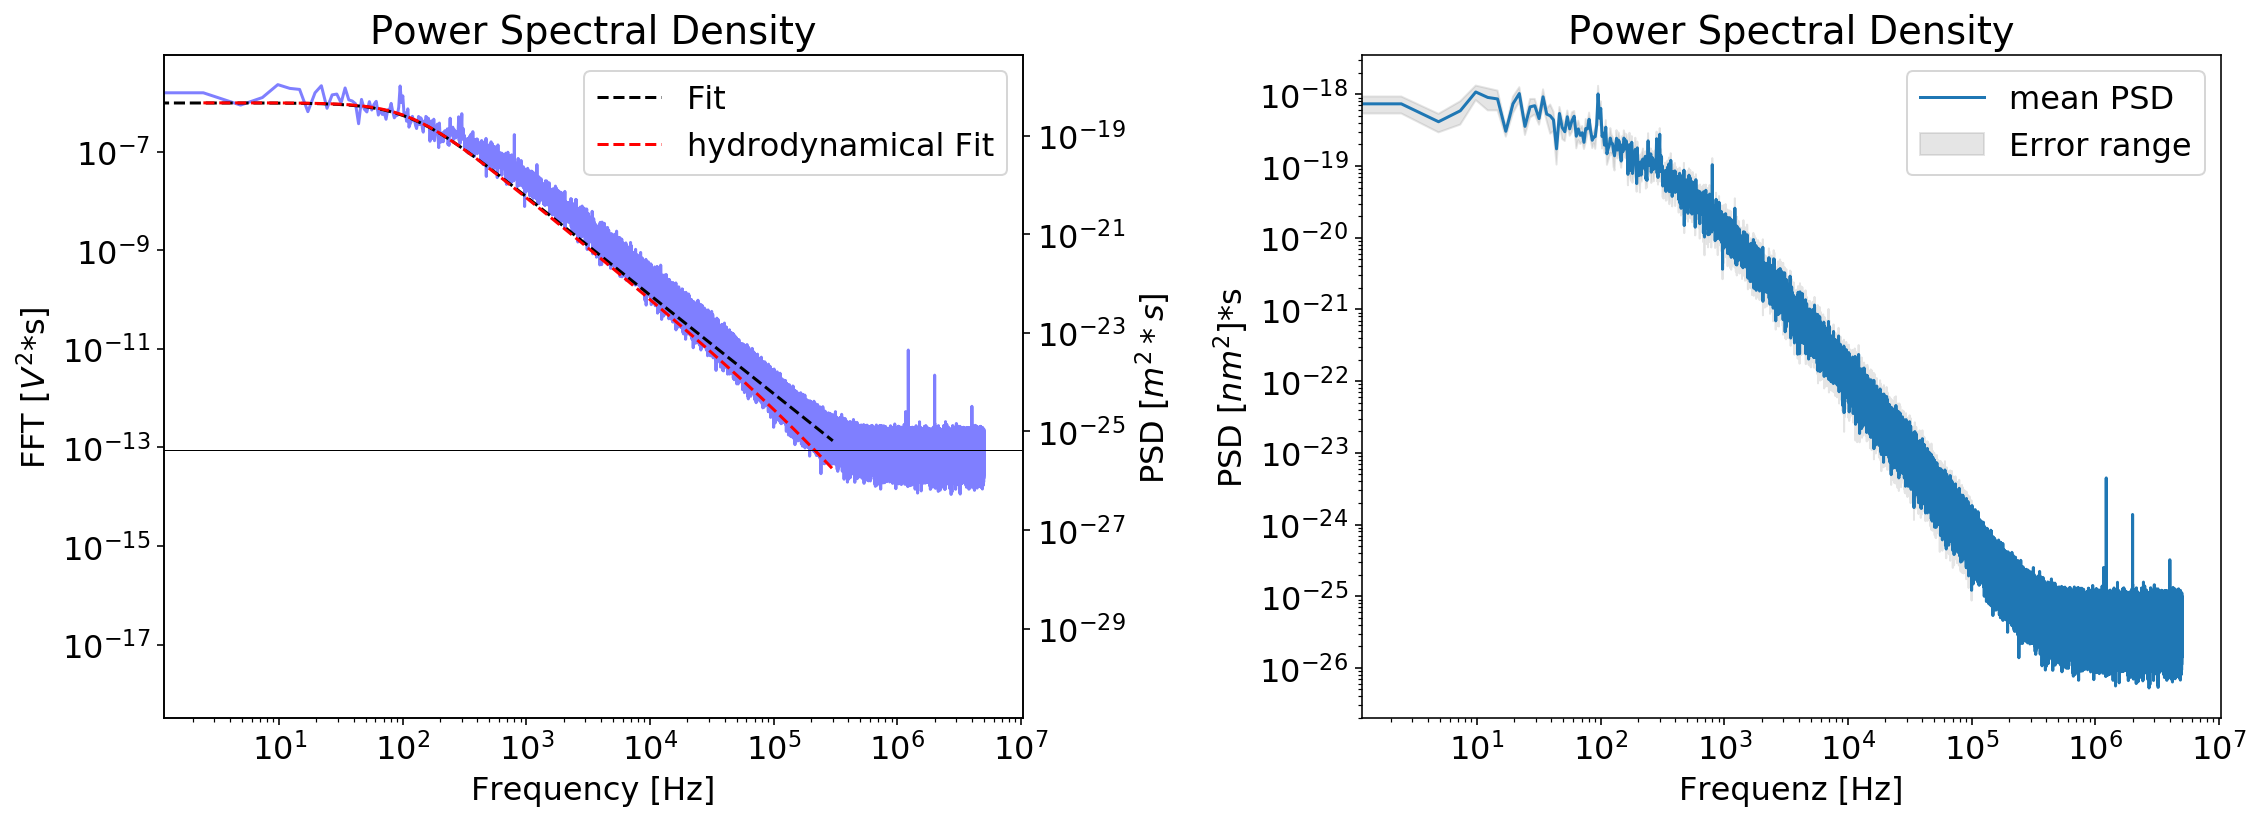

spatial resolution =  0.0  nm
temporal resolution =  2.051  µs
--- 10.36 seconds ---


In [53]:
start_time = time.time()
Conversiontom = Vtom**2
PSDinm = PSDmean*Conversiontom
fitfreq = 3e5
df = 1/(dt*length)
fitlength = int(fitfreq/df)
PSDmax = 1.1*PSD[:fitlength].max()
PSDmin = 0.99*PSD[:fitlength].min()
PSDerr2 = 0.1*PSDinm

#popt,pcov = curve_fit(fitPSD, freq[:fitlength], PSDinm[:fitlength],p0 = (1/(2*np.pi*taukACF),0.6))
popt,pcov = curve_fit(fitPSD, freq[:fitlength], PSDinm[:fitlength], sigma = PSDerr2[:fitlength], absolute_sigma=True, p0 = (1/(2*np.pi*taukACF),0.6))
pErr = np.sqrt(np.diag(pcov))
r,redchi2 = chi2(PSDinm[:fitlength],2,fitPSD,freq[:fitlength],*popt)
fkPSD = popt[0]; fkPSDerr = pErr[0]; APSD = popt[1]; APSDerr = pErr[1]
taukPSD = 1/(2*np.pi*fkPSD); taukPSDerr = 1/(2*np.pi*pow(fkPSD,2))*fkPSDerr
print('From the simple fit:')
print('tau_k = ',round(taukPSD*1e3,3),' +- ',round(taukPSDerr*1e3,3),' ms')

A = APSD; f_k = fkPSD
popt,pcov = curve_fit(fitPSDhydro, freq[:fitlength], PSDinm[:fitlength], sigma = PSDerr2[:fitlength], absolute_sigma=True ,p0 = (f_f))
pErr = np.sqrt(np.diag(pcov))
r,redchi2 = chi2(PSDinm[:fitlength],1,fitPSDhydro,freq[:fitlength],*popt)
f_fPSDhydro = popt[0]; f_fPSDhydroerr = pErr[0]#; f_pPSDhydro = popt[1]; f_pPSDhydroerr = pErr[1]
taufPSDhydro = 1/(2*np.pi*f_fPSDhydro); taufPSDhydroerr = 1/(2*np.pi*pow(f_fPSDhydro,2))*f_fPSDhydroerr
print(' ')
print('From the hydrodynamic fit:')
print('tau_f = ',round(taufPSDhydro*1e6,3),' +- ',round(taufPSDhydroerr*1e6,3),' µs - theory: ',round(tau_f*1e6,3))

fitfreq2 = 1e6
df = 1/(dt*length)
fitlength2 = int(fitfreq2/df)
fitmean = np.mean(PSDinm[fitlength2:int(length/2)])

fig, ax1 = plt.subplots(figsize=(16,6))
ax = plt.subplot(121)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('FFT [$V^{2}$*s]')
ax.tick_params(axis='y')
plt.loglog(freq,PSDmean,c='k',alpha=0)
plt.ylim([PSDmin,PSDmax])
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
plt.loglog(freq,PSDinm,color = 'b',alpha=0.5)
plt.plot(freq[:fitlength],fitPSD(freq[:fitlength],fkPSD,A),'k--',label='Fit')
plt.plot(freq[:fitlength],fitPSDhydro(freq[:fitlength],f_fPSDhydro),'r--',label='hydrodynamical Fit')

plt.axhline(y=fitmean,linewidth=0.5, color = 'k',linestyle='-')
plt.ylim([PSDmin*Conversiontom,PSDmax*Conversiontom])
ax2.set_ylabel('PSD [$m^{2}*s$]')  # we already handled the x-label with ax1
ax2.tick_params(axis='y')
plt.title('Power Spectral Density')
plt.legend()

plt.subplot(122)  
plotfreq = 1e5
df = 1/(dt*length)
plotlength = int(plotfreq/df)
plt.loglog(freq, PSDinm,label = 'mean PSD')
plt.fill_between(freq[:plotlength], PSDinm[:plotlength] - PSDerr[:plotlength]*Conversiontom, 
                 PSDinm[:plotlength] + PSDerr[:plotlength]*Conversiontom,
                 color='gray', alpha=0.2, label = 'Error range')
plt.xlabel('Frequenz [Hz]')
plt.ylabel('PSD [$nm^{2}$]*s')
plt.title('Power Spectral Density') 
plt.legend()
plt.tight_layout()  
plt.savefig('PSD.pdf', format='pdf')
plt.show()

freqintersection = np.sqrt(kB*T/(2*pow(np.pi,2)*drag*fitmean)-pow(fkPSD,2))
tempres = 1/freqintersection
spatres = np.sqrt(fitPSD(freqintersection,fkPSD,APSD))
print('spatial resolution = ',round(spatres*1e9,3),' nm')
print('temporal resolution = ',round(tempres*1e6,3),' µs')
print("--- %s seconds ---" % round((time.time() - start_time),2))  

In [40]:
start_time = time.time()
xtemp = np.zeros((length,1))
MSD = np.zeros((length,datasets))
MSDmean = np.zeros(length)
for i in range(datasets):
    xtemp[:,0] = x[:,i]
    r = xtemp[:length]
    start_time = time.time()
    MSDcalc = msd_fft(r)
    MSD[:,i] = MSDcalc
    MSDmean += MSDcalc
MSDmean /= datasets

#MSDerr = np.zeros(length)
#for i in range(length):
#    MSDerr[i] = np.std(MSD[i,:])/np.sqrt(datasets)
print("--- %s seconds ---" % round((time.time() - start_time),2))

--- 4.39 seconds ---


tau_k =  0.964  +-  0.0  ms
spatial resolution =  0.832  nm


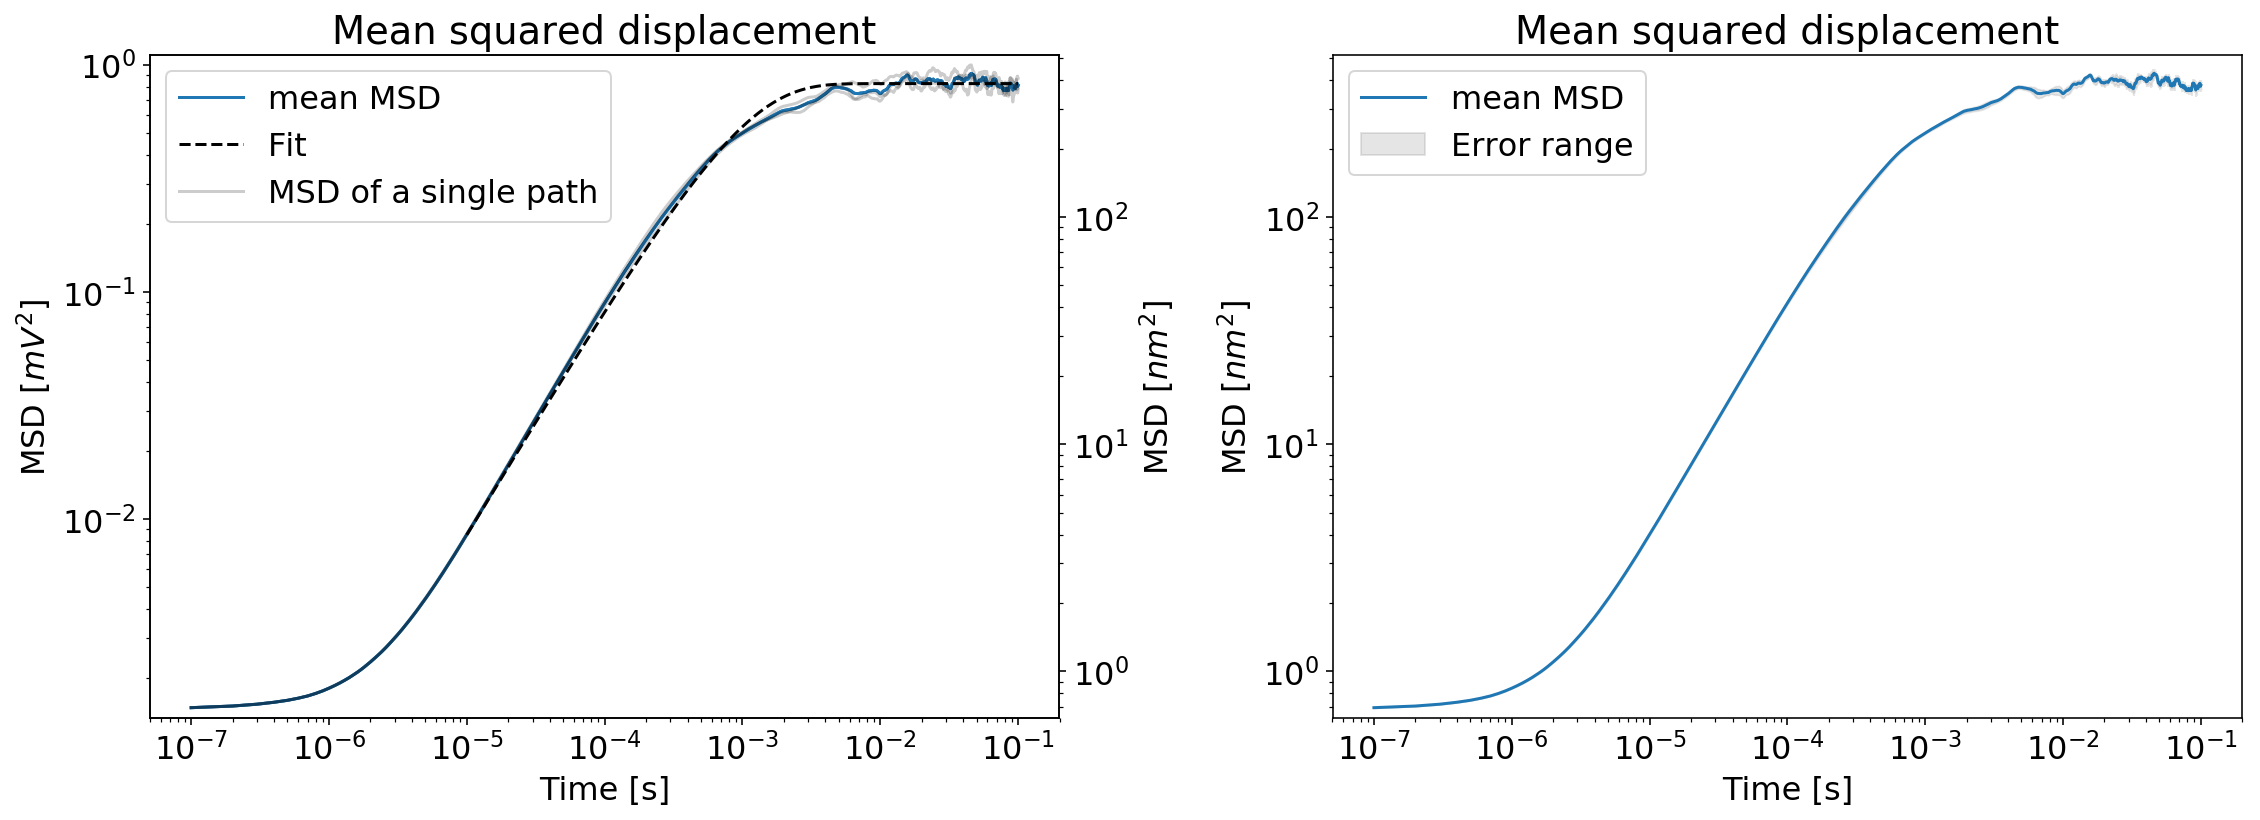

--- 23.1 seconds ---


In [47]:
start_time = time.time()
plottime = 0.1
plotlength = int(plottime/dt)
fittimestart = 1e-5
fitlengthstart = int(fittimestart/dt)
fittimeend = 0.1
fitlengthend = int(fittimeend/dt)

popt,pcov = curve_fit(fitMSD, timewave[fitlengthstart:fitlengthend], MSDmean[fitlengthstart:fitlengthend]*Conversiontom,p0 = (taukACF))
pErr = np.sqrt(np.diag(pcov))
r,redchi2 = chi2(MSDmean,1,fitMSD,timewave,*popt)
taukMSD = popt[0]; taukMSDerr = pErr[0]
print('tau_k = ',round(taukMSD*1e3,3),' +- ',round(taukMSDerr*1e3,3),' ms')

Conversiontonm = Vtom**2*1e18
MSDinnm = MSDmean*Conversiontonm

MSDmax = 1.1*MSD[1:plotlength].max()
MSDmin = 0.9*MSD[1:plotlength].min()
spatres = np.sqrt(MSDinnm[1])
print('spatial resolution = ',round(spatres,3),' nm')

fig, ax1 = plt.subplots(figsize=(16,6))
ax = plt.subplot(121)
ax.set_xlabel('Time [s]')
ax.set_ylabel('MSD [$mV^{2}$]')
ax.tick_params(axis='y')
plt.loglog(timewave[1:plotlength],MSDmean[1:plotlength]*1e3)
plt.ylim([MSDmin*1e3,MSDmax*1e3])
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
plt.loglog(timewave[1:plotlength],MSDinnm[1:plotlength],label='mean MSD')
plt.loglog(timewave[fitlengthstart:fitlengthend],fitMSD(timewave[fitlengthstart:fitlengthend],*popt)*1e18,'k--',label='Fit')
for i in range(datasets):
    if i == 0:
        plt.plot(timewave[1:plotlength],MSD[1:plotlength,i]*Conversiontonm,c='k',alpha=0.2,label = 'MSD of a single path')
    else:
        plt.plot(timewave[1:plotlength],MSD[1:plotlength,i]*Conversiontonm,c='k',alpha=0.2)
plt.ylim([MSDmin*Conversiontonm,MSDmax*Conversiontonm])
ax2.set_ylabel('MSD [$nm^{2}$]')  # we already handled the x-label with ax1
ax2.tick_params(axis='y')
plt.title('Mean squared displacement')
plt.legend()

plt.subplot(122)
plt.loglog(timewave[1:plotlength], MSDinnm[1:plotlength],label = 'mean MSD')
plt.fill_between(timewave[1:plotlength], MSDinnm[1:plotlength] - MSDerr[1:plotlength]*Conversiontonm, 
                 MSDinnm[1:plotlength] + MSDerr[1:plotlength]*Conversiontonm,
                 color='gray', alpha=0.2, label = 'Error range')
plt.axhline(y=0,linewidth=0.5, color = 'k',linestyle='-')
plt.xlabel('Time [s]')
plt.ylabel('MSD [$nm^{2}$]')
plt.ylim([MSDmin*Conversiontonm,MSDmax*Conversiontonm])
plt.title('Mean squared displacement')
plt.legend()
plt.tight_layout()  
plt.savefig('MSD.pdf', format='pdf')
plt.show()
print("--- %s seconds ---" % round((time.time() - start_time),2))  